In [56]:
#Extract the file and unzip
import tarfile

file_path = "GSE58135_RAW.tar"

with tarfile.open(file_path) as tar:
    tar.extractall(path="GSE58135_RAW_files")


/var/folders/h9/qgsr_yv10wl4r1rt1jy83pd00000gn/T/ipykernel_18119/2053525775.py:7: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path="GSE58135_RAW_files")


In [57]:
import os

folder = "GSE58135_RAW_files"
print("Files extracted:", os.listdir(folder))


Files extracted: ['GSM1401788_SL12608_chimeras.bedpe.gz', 'GSM1401719_SL13095_chimeras.bedpe.gz', 'GSM1401711_SL10857_chimeras.bedpe.gz', 'GSM1401783_SL10812_chimeras.bedpe.gz', 'GSM1401807_SL8236_chimeras.bedpe.gz', 'GSM1401717_SL13098_gene.fpkm_tracking.gz', 'GSM1401761_SL10636_gene.fpkm_tracking.gz', 'GSM1401798_SL8217_chimeras.bedpe.gz', 'GSM1401755_SL8362_gene.fpkm_tracking.gz', 'GSM1401701_SL10806_chimeras.bedpe.gz', 'GSM1401761_SL10636_chimeras.bedpe.gz', 'GSM1401717_SL13098_chimeras.bedpe.gz', 'GSM1401731_SL7914_chimeras.bedpe.gz', 'GSM1401709_SL10854_chimeras.bedpe.gz', 'GSM1401780_SL10802_gene.fpkm_tracking.gz', 'GSM1401711_SL10857_gene.fpkm_tracking.gz', 'GSM1401734_SL7917_chimeras.bedpe.gz', 'GSM1401806_SL8235_chimeras.bedpe.gz', 'GSM1401800_SL8219_gene.fpkm_tracking.gz', 'GSM1401656_SL6570_gene.fpkm_tracking.gz', 'GSM1401789_SL13099_chimeras.bedpe.gz', 'GSM1401712_SL10858_gene.fpkm_tracking.gz', 'GSM1401690_SL10661_chimeras.bedpe.gz', 'GSM1401792_SL13091_chimeras.bedpe.gz'

In [73]:
# Read the file as csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ---- Load and Preprocess Data ----
df = pd.read_csv('GSM1401648_SL5421_chimeras.bedpe.gz', compression='gzip', sep='\t', header=None)
df.columns = df.iloc[0]
df = df[1:].reset_index(drop=True)

# ---- Basic Dataset Info ----
print(f"Dataset shape: {df.shape}")
print(df.describe())

Dataset shape: (318, 23)
0      #chrom5p   start5p     end5p chrom3p start3p end3p chimera_cluster_id  \
count       318       318       318     318     318   318                318   
unique       24       277       279      24     271   273                318   
top        chr1  28763107  28763912    chr1    1708  4261         CLUSTER307   
freq         44         4         4      37       7     7                  1   

0      score strand5p strand3p  ... genes3p              type distance  \
count    318      318      318  ...     318               318      153   
unique    20        2        2  ...     259                11      130   
top        2        +        +  ...    SMA3  Interchromosomal        0   
freq     185      164      164  ...       8               165       24   

0      total_frags spanning_frags unique_alignment_positions  \
count          318            318                        318   
unique          20              5                         17   
top        

In [74]:
# ---- Unique Counts ----
num_chimeras = df['chimera_cluster_id'].nunique()
unique_genes_5p = pd.Series(','.join(df['genes5p'].dropna()).split(',')).nunique()
unique_genes_3p = pd.Series(','.join(df['genes3p'].dropna()).split(','))
unique_genes_3p = unique_genes_3p.nunique()

print(f"Unique chimera clusters: {num_chimeras}")
print(f"Unique 5' genes: {unique_genes_5p}")
print(f"Unique 3' genes: {unique_genes_3p}")

Unique chimera clusters: 318
Unique 5' genes: 290
Unique 3' genes: 276


/var/folders/h9/qgsr_yv10wl4r1rt1jy83pd00000gn/T/ipykernel_18119/1751537572.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='type', data=df, order=df['type'].value_counts().index, palette='coolwarm')


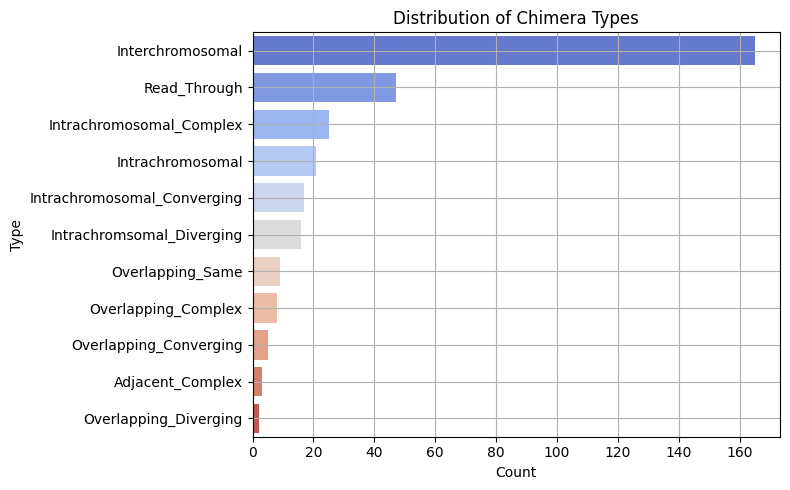

In [75]:
# ---- Chimera Type Distribution ----
plt.figure(figsize=(8,5))
sns.countplot(y='type', data=df, order=df['type'].value_counts().index, palette='coolwarm')
plt.title('Distribution of Chimera Types')
plt.xlabel('Count')
plt.ylabel('Type')
plt.grid(True)
plt.tight_layout()
plt.show()

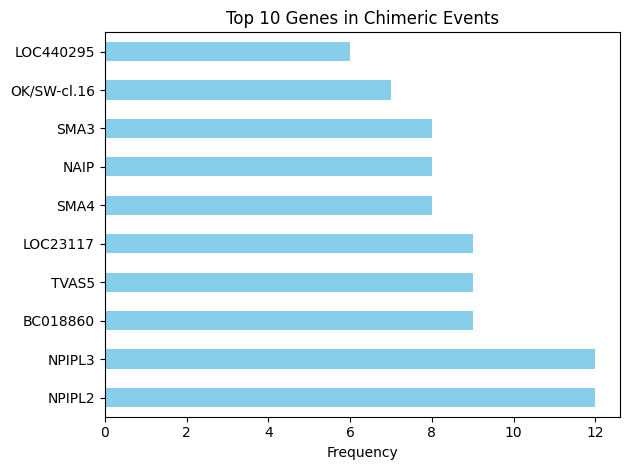

In [76]:
# ---- Top Genes in Chimeras ----
genes = df['genes5p'].dropna().tolist() + df['genes3p'].dropna().tolist()
gene_counts = Counter(g for line in genes for g in line.split(','))
top_genes = pd.Series(gene_counts).nlargest(10)
top_genes.plot(kind='barh', title='Top 10 Genes in Chimeric Events', color='skyblue')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

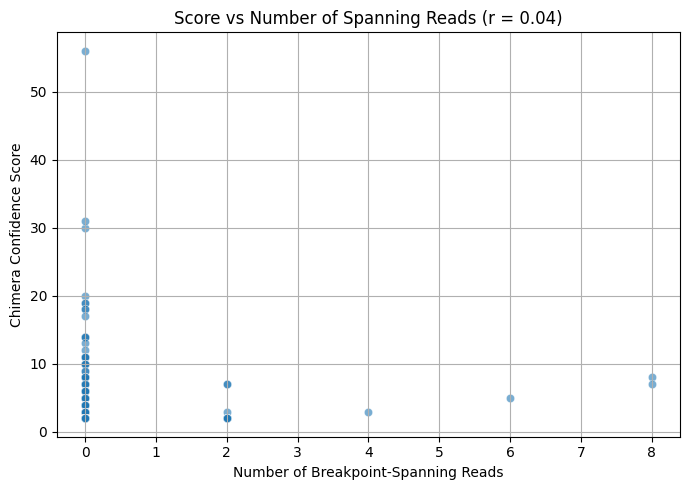

In [77]:
# ---- Score vs Number of Spanning Reads ----
df['score'] = pd.to_numeric(df['score'], errors='coerce')
df['num_reads'] = df['breakpoint_spanning_reads'].apply(
    lambda x: len(str(x).split(',')) if pd.notnull(x) and str(x).strip() != '' else 0
)
correlation = df['score'].corr(df['num_reads'])

plt.figure(figsize=(7,5))
sns.scatterplot(x='num_reads', y='score', data=df, alpha=0.6)
plt.title(f'Score vs Number of Spanning Reads (r = {correlation:.2f})')
plt.xlabel('Number of Breakpoint-Spanning Reads')
plt.ylabel('Chimera Confidence Score')
plt.grid(True)
plt.tight_layout()
plt.show()

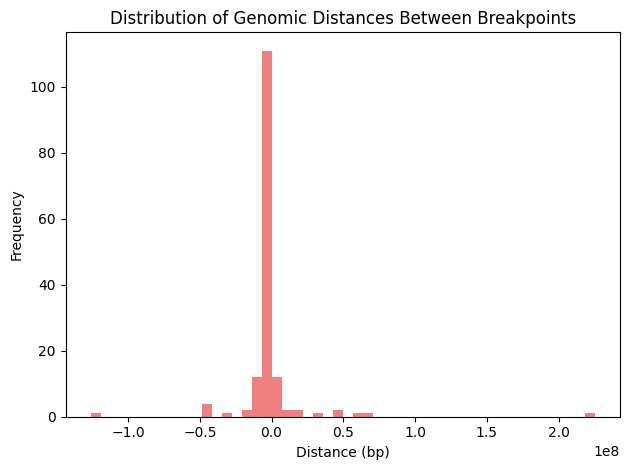

In [78]:
# ---- Genomic Distance Distribution ----
df['distance'] = pd.to_numeric(df['distance'], errors='coerce')
df['distance'].hist(bins=50, color='lightcoral')
plt.title('Distribution of Genomic Distances Between Breakpoints')
plt.xlabel('Distance (bp)')
plt.ylabel('Frequency')
plt.grid(False)
plt.tight_layout()
plt.show()

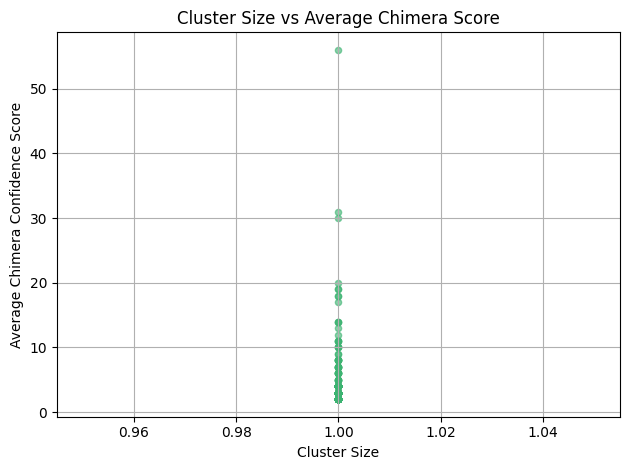

In [79]:
# ---- Average Score per Cluster ----
cluster_scores = df.groupby('chimera_cluster_id')['score'].mean()
cluster_sizes = df['chimera_cluster_id'].value_counts()
merged = pd.DataFrame({'cluster_size': cluster_sizes, 'avg_score': cluster_scores})

merged.plot.scatter(x='cluster_size', y='avg_score', alpha=0.6, color='mediumseagreen')
plt.title('Cluster Size vs Average Chimera Score')
plt.xlabel('Cluster Size')
plt.ylabel('Average Chimera Confidence Score')
plt.grid(True)
plt.tight_layout()
plt.show()

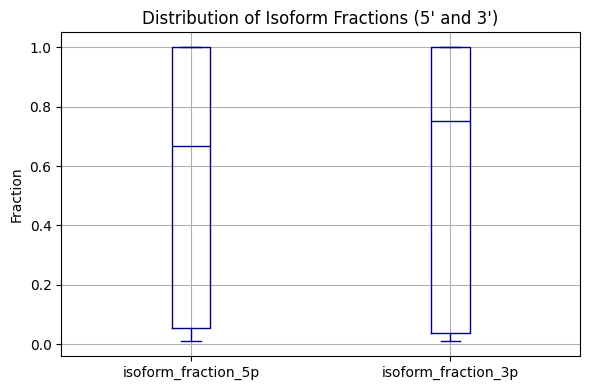

In [80]:
# ---- Isoform Fractions ----
df['isoform_fraction_5p'] = pd.to_numeric(df['isoform_fraction_5p'], errors='coerce')
df['isoform_fraction_3p'] = pd.to_numeric(df['isoform_fraction_3p'], errors='coerce')

df[['isoform_fraction_5p', 'isoform_fraction_3p']].plot(kind='box', figsize=(6,4), color='darkblue')
plt.title('Distribution of Isoform Fractions (5\' and 3\')')
plt.ylabel('Fraction')
plt.grid(True)
plt.tight_layout()
plt.show()

In [81]:
# ---- Summary Statistics ----
summary_stats = df[['score', 'distance', 'total_frags', 'spanning_frags',
                    'isoform_fraction_5p', 'isoform_fraction_3p']].describe()
print(summary_stats)

0           score      distance  isoform_fraction_5p  isoform_fraction_3p
count  318.000000  1.530000e+02           318.000000           318.000000
mean     3.852201  2.810568e+05             0.557570             0.565994
std      4.765827  2.474205e+07             0.446656             0.450835
min      2.000000 -1.258990e+08             0.010363             0.010101
25%      2.000000 -3.502300e+04             0.054429             0.038776
50%      2.000000  0.000000e+00             0.666667             0.750000
75%      4.000000  1.456000e+04             1.000000             1.000000
max     56.000000  2.252042e+08             1.000000             1.000000


In [ ]:
# --- Correlation Matrix ---
numeric_cols = df[['score', 'distance', 'total_frags', 'spanning_frags',
                   'isoform_fraction_5p', 'isoform_fraction_3p']].apply(pd.to_numeric, errors='coerce')
correlation_matrix = numeric_cols.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)


Correlation Matrix:
0                       score  distance  total_frags  spanning_frags  \
0                                                                      
score                1.000000 -0.121833     1.000000        0.051242   
distance            -0.121833  1.000000    -0.121833       -0.038854   
total_frags          1.000000 -0.121833     1.000000        0.051242   
spanning_frags       0.051242 -0.038854     0.051242        1.000000   
isoform_fraction_5p  0.059137  0.048296     0.059137       -0.007341   
isoform_fraction_3p  0.156809 -0.059096     0.156809       -0.033629   

0                    isoform_fraction_5p  isoform_fraction_3p  
0                                                              
score                           0.059137             0.156809  
distance                        0.048296            -0.059096  
total_frags                     0.059137             0.156809  
spanning_frags                 -0.007341            -0.033629  
isoform_fraction_5